In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson
from sklearn.utils import resample

def pan_private_uniformity(eps, data, k, alpha):
    #k = 20
    bins = np.linspace(0,1,k)
    m_prime = poisson.rvs(mu=m, size=1)
    #print('m_prime is: ' + str(m_prime))
    data_poissoned = resample(data, replace=True, n_samples=m_prime.item())
    
    #add normal noise here if you want to test the non-uniform case
    #normal_noise = np.random.normal(loc=0.0, scale=5.0, size = k-1)

    histogram = np.random.laplace(loc=0.0, scale=1/eps, size = k-1)
    histogram += np.histogram(a=data_poissoned,bins=bins)[0]
    histogram += np.random.laplace(loc=0.0, scale=1/eps, size = k-1)
    #histogram += normal_noise

    z_prime = np.sum(((histogram - m/k)**2 - histogram) / (m/k))

    
    t_u = 1/100 * alpha**2 * m + 4*(k**2)/(eps**2 * m) + 24*np.sqrt(2) * (k**(3/2)) / (eps**2 * m)
    t_u += 16*np.sqrt(2) * k /(eps*np.sqrt(m)) + 8*np.sqrt(2)*(k**(3/2)) / (eps*m)
    
    return z_prime, t_u

As we note in the paper, the Laplaced chi-square statistic has huge variance! We can see below that even if we meet the required sample complexity, we aren't guaranteed to get a consistently "good" answer. Though the variance does seem to decay with larger n, even in log form, this may not be particularly useful for actual hypothesis testing. We may need even larger samples to begin to see consistency. 

In [67]:
eps = 1
m = 500 
k = 20
data = np.random.uniform(0,1,m)
alpha = 1/2

num_experiments = 1000
count = 0
for experiment in range(num_experiments):
    z_prime, t_u = pan_private_uniformity(1, data=data, k=k, alpha=alpha)
    #print(z_prime, t_u)
    if z_prime > t_u:
        count += 1
    else:
        pass
print(str(count / num_experiments) + ' not-uniform')

0.685 not-uniform


In [68]:
#sample complexity
print(k**(3/4)/ (alpha*eps) + np.sqrt(k)/alpha**2)

36.80337600006183


In [69]:
variance_list = []
num_experiments = 200
for size in np.arange(10,1000,10):
    z_prime_list = []
    for experiment in range(num_experiments):
        z_prime, t_u = pan_private_uniformity(1, data=np.random.uniform(0,1,size), k=k, alpha=alpha)
        z_prime_list.append(z_prime)
        
    variance_list.append(np.var(z_prime_list))

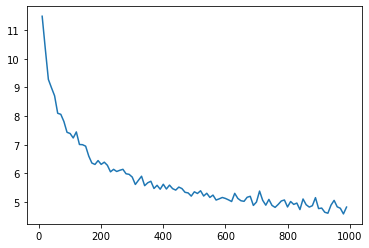

In [70]:
plt.plot(np.arange(10,1000,10), np.log(variance_list))

### RAPPOR: Encode, Perturb, Aggregate

In [71]:
def locally_private_uniformity(eps, data, k, alpha):
    #encode
    bins = np.linspace(0,1,k)
    k_ary_encodings = np.zeros((m, k-1))
    for d in range(len(data)):
        for b in range(len(bins)-1):
            #print(b, b+1)
            #print(bins[b], bins[b+1])
            if (data[d] >= bins[b]) & (data[d] <= bins[b+1]):
                k_ary_encodings[d, b] = 1
            else:
                pass
    
    #perturb
    perturb_matrix = np.random.uniform(0,1,size=(m,k-1))
    p_flip = 1 / (np.e**(eps/2)+1 )

    for d in range(len(data)):
        for b in range(len(bins)-1):
            if perturb_matrix[d,b] < p_flip:
                if k_ary_encodings[d,b] == 0:
                    k_ary_encodings[d,b] = 1
                elif k_ary_encodings[d,b] == 1:
                    k_ary_encodings[d,b] = 0
            else:
                pass
            
    #aggregate
    a_R = (np.e**(eps/2) - 1)/ (np.e**(eps/2) + 1)
    b_R = 1/ (np.e**(eps/2) + 1)

    #aggregate
    histogram = k_ary_encodings.sum(axis=0)
    histogram = (histogram - m*(p_flip)) / (a_R)
    #histogram
    
    return histogram

In [72]:
bins = np.linspace(0,1,k)
k_ary_encodings = np.zeros((m, k-1))
for d in range(len(data)):
    for b in range(len(bins)-1):
        #print(b, b+1)
        #print(bins[b], bins[b+1])
        if (data[d] >= bins[b]) & (data[d] <= bins[b+1]):
            k_ary_encodings[d, b] = 1
        else:
            pass
    

In [73]:
eps = 1
private = locally_private_uniformity(eps=eps, data=data, k=k, alpha=alpha)
print(private.sum(axis=0))

364.8707107109579


Below, we check that the distance between the histograms, measured by the l2 norm, is indeed decreasing as the privacy budget increases. The plot below meets the eye test, but we note that at epsilon=1, we have a long way to go before we can even get remotely close to small error.  

Text(0, 0.5, 'L2 Distance')

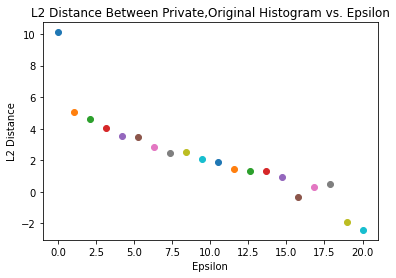

In [75]:
import matplotlib.pyplot as plt

eps_grid = np.linspace(0.01, 20, 20)

for e in eps_grid:
    private = locally_private_uniformity(eps=e, data=data, k=k, alpha=alpha)
    distance = np.linalg.norm(private - k_ary_encodings.sum(axis=0))
    plt.scatter(e, np.log(distance))
plt.title('L2 Distance Between Private,Original Histogram vs. Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('L2 Distance')

In [80]:
eps = 1
a_R = (np.e**(eps/2) - 1)/ (np.e**(eps/2) + 1)
b_R = 1/ (np.e**(eps/2) + 1)

t_u_vals = (private - (m -1)*(a_R/k + b_R))**2 - private
t_u_vals += k * (m-1)*(a_R/k + b_R)**2
t_u_rappor = np.sum(t_u_vals)

In [81]:
alpha = 1/3
thresh = m * (m-1) * a_R**2 * alpha**2 / k
print(t_u_rappor, m**2 * alpha**2 / k, thresh)

566837.2366181464 1388.888888888889 83.14608457115943
